# Scoring your trained model

In the cell below, please load your model into `model`. Also if you used an image size for your input images that *isn't* 224x224, you'll need to set `image_size` to the size you used. The scoring code assumes square input images.

For example, this is how I loaded in my checkpoint:

```python
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models

class FFClassifier(nn.Module):
    
    def __init__(self, in_features, hidden_features, 
                       out_features, drop_prob=0.1):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p=drop_prob)
        
    def forward(self, x):
        x = self.drop(F.relu(self.fc1(x)))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

    
def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    
    model = models.vgg16(pretrained=False)
    for param in model.parameters():
        param.requires_grad = False

    # Put the classifier on the pretrained network
    model.classifier = FFClassifier(25088, checkpoint['hidden'], 102)
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

model = load_checkpoint('/home/workspace/classifier.pt')
```

Your exact code here will depend on how you defined your network in the project. Make sure you use the absolute path to your checkpoint which should have been uploaded to the `/home/workspace` directory.

Run the cell, then after loading the data, press "Test Code" below. This can take a few minutes or more depending on the size of your network. Your model needs  to reach **at least 20% accuracy** on the test set to be recorded.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.models as models

In [2]:
# Load your model to this variable
model = models.resnet18(pretrained=True)
for param in model.fc.parameters():
    param.requires_grad = False
in_features=model.fc.in_features
model.fc = nn.Linear(in_features, 102)
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
chpt = torch.load("full5cpu.pth")
model.class_to_idx = chpt['class_to_idx']
model.load_state_dict(chpt['state_dict'],strict=False)
model.eval()
model.to(device)
   
# If you used something other than 224x224 cropped images, set the correct size here
image_size = 224
# Values you used for normalizing the images. Default here are for 
# pretrained models from torchvision.
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

## Use

In [11]:
model.to("cpu")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [12]:
import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
label_map=cat_to_name
#image_datasets['train'].class_to_idx=cat_to_name
#image_datasets['valid'].class_to_idx=cat_to_name

In [13]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)

    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))

    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224

    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

In [14]:
def imshow2(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    if title:
        plt.title(title)

    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [15]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).cpu().type(torch.FloatTensor)#torch.FloatTensor)

    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [label_map[idx_to_class[lab]] for lab in top_labs]

    return top_probs, top_labels, top_flowers

In [16]:
import seaborn as sns
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)

    # Set up title
    flower_num = image_path.split('/')[3]
    title_ = cat_to_name[flower_num]

    # Plot flower
    img = process_image(image_path)
    imshow2(img, ax, title = title_);

    # Make prediction
    probs, labs, flowers = predict(image_path, model) 

    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

tensor([[[[-1.7583, -1.7240, -1.7240,  ..., -2.0323, -1.9638, -1.9467],
          [-1.3473, -1.2959, -1.4843,  ..., -1.9809, -1.9809, -1.9809],
          [-1.8439, -1.8610, -1.8439,  ..., -1.9295, -1.9638, -1.9638],
          ...,
          [-1.5357, -1.5870, -1.6042,  ..., -1.2274, -1.4843, -1.3130],
          [-1.5870, -1.6042, -1.5870,  ..., -1.4843, -1.5185, -1.2274],
          [-1.8097, -1.7069, -1.6555,  ..., -1.9980, -1.3987, -1.1075]],

         [[-1.4580, -1.4230, -1.4055,  ..., -1.9307, -1.8957, -1.8782],
          [-1.0903, -1.0378, -1.2129,  ..., -1.8782, -1.8782, -1.8606],
          [-1.6506, -1.6506, -1.6506,  ..., -1.8081, -1.7906, -1.7906],
          ...,
          [-1.1779, -1.1779, -1.1779,  ..., -0.7577, -0.9853, -0.8102],
          [-1.3004, -1.2479, -1.2129,  ..., -0.9503, -0.9678, -0.6702],
          [-1.6155, -1.4230, -1.3004,  ..., -1.4755, -0.8277, -0.5476]],

         [[-1.4733, -1.4559, -1.4384,  ..., -1.7696, -1.7522, -1.7347],
          [-1.0201, -0.9678, -

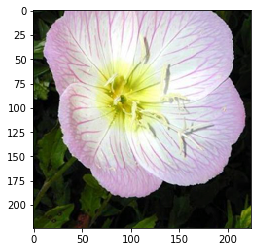

In [17]:
data_dir = './flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
image_path=test_dir+"/1/image_06743.jpg"
img = process_image(image_path) 
imshow2(img)
img = torch.from_numpy(img).type(torch.FloatTensor) 
img.unsqueeze_(0)

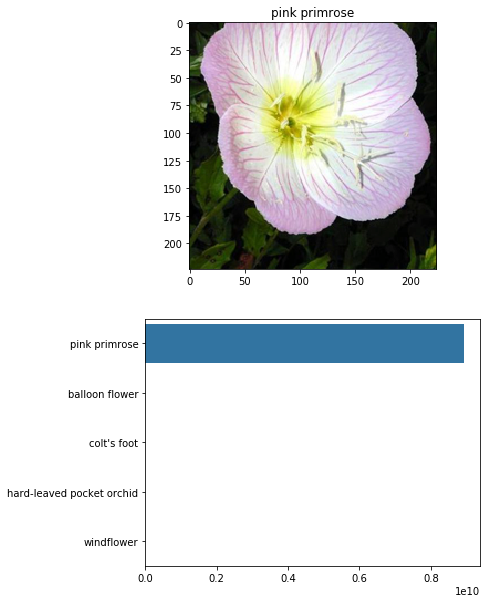

In [18]:
plot_solution(image_path, model)